### Loading libraries

In [ ]:
# library to display a progress bar
import tqdm

# importing gensim to train a Word2Vec model
import gensim

# library for making HTTP requests
import requests

# library to operate large, multi-dimensional arrays and matrices
import numpy as np

# library for data manipulation and analysis
import pandas as pd

# library to access the financial data available on Yahoo Finance.
import yfinance as yf

# library for statistical data visualization
import seaborn as sns

# library to create, manipulate, and study complex networks.
import networkx as nx

# library for pulling data out of HTML and XML files
from bs4 import BeautifulSoup

# library for data visualization
import matplotlib.pyplot as plt

# importing word2vec algorithm from gensim
from gensim.models import Word2Vec

# library for machine learning on graphs and networks
from stellargraph import StellarGraph

# class used to perform biased random walks on the graph/networks
from stellargraph.data import BiasedRandomWalk

### Fetching the list of stock tickers

![Image Title](snp_500_tickers.png)

In [ ]:
# retrieving the content of the web page of a given URL.
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

# using the BeautifulSoup library to parse the HTML content of the resp.text variable using the 'lxml' parser
soup = BeautifulSoup(resp.text, 'lxml')

# searching for a <table> element with the attribute class set to 'wikitable sortable' in the above parse HTML document
table = soup.find('table', {'class': 'wikitable sortable'})

# creating an empty list to store all the tickers mentioned in above table
tickers = []

# iterate over each row in the above table, excluding the header row
for row in table.findAll('tr')[1:]:

    # extracting the text value from the first cell of each row in a table
    ticker = row.findAll('td')[0].text.strip('\n')

    # then appending the ticker into the empty list tickers
    tickers.append(ticker)

# replacing any occurrences of the dot character '.' with the hyphen character '-' in each element of the tickers list
tickers = [ticker.replace('.', '-') for ticker in tickers]

### Fetching the EOD price data for above tickers

In [ ]:
# defining start date from when we want to fetch price data
start_date = '2022-01-01'

# defining end date from when we want to fetch price data
end_date = '2022-12-31'

# downloanding price data for all S&P 500 tickers for above time period
data = yf.download(tickers, start=start_date, end=end_date)

# fetching only the EOD close prices
price_data = data['Close']

In [ ]:
# printing first 5 rows of the dataframe
price_data.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,156.479996,18.750000,236.779999,182.009995,135.419998,132.619995,139.039993,44.549999,407.209991,564.369995,...,87.769997,67.940002,63.540001,56.889999,116.889999,136.529999,125.368935,583.900024,64.239998,234.029999
1,151.190002,19.020000,237.050003,179.699997,135.160004,131.360001,135.770004,45.130001,404.299988,554.000000,...,87.489998,68.370003,65.930000,57.180000,118.129997,137.259995,126.640778,587.599976,66.070000,225.119995
2,148.600006,18.680000,236.449997,174.919998,135.869995,132.500000,135.160004,44.599998,397.179993,514.429993,...,84.250000,69.040001,66.750000,56.259998,116.519997,135.520004,126.223305,558.179993,66.220001,216.559998
3,149.119995,18.570000,241.649994,172.000000,135.229996,130.449997,135.139999,44.860001,378.000000,514.119995,...,84.639999,68.500000,68.320000,56.220001,116.360001,136.919998,125.174759,555.159973,68.940002,217.419998
4,145.149994,19.280001,238.089996,172.169998,134.880005,133.119995,135.559998,45.070000,370.750000,510.700012,...,84.550003,69.099998,68.879997,56.400002,115.430000,135.350006,124.417473,530.859985,70.089996,211.089996


### Modeling the data

In [ ]:
# computing the logarithmic returns of a financial time series data i.e. the EOD price data
log_returns_data = np.log(price_data / price_data.shift(1))

# computing the correlation matrix of the logarithmic returns data.
log_return_correlation = log_returns_data.corr()

# computing a distance matrix based on the correlation matrix of logarithmic returns.
distance_matrix = np.sqrt(2 * (1 - log_return_correlation))

# creating a graph object from the above distance matrix using the NetworkX library.
distance_graph = nx.Graph(distance_matrix)

# filtering the above fully connected graph using a minimum spanning tree (MST)
distance_graph_filtered = nx.minimum_spanning_tree(distance_graph)

### Visualizing the graph

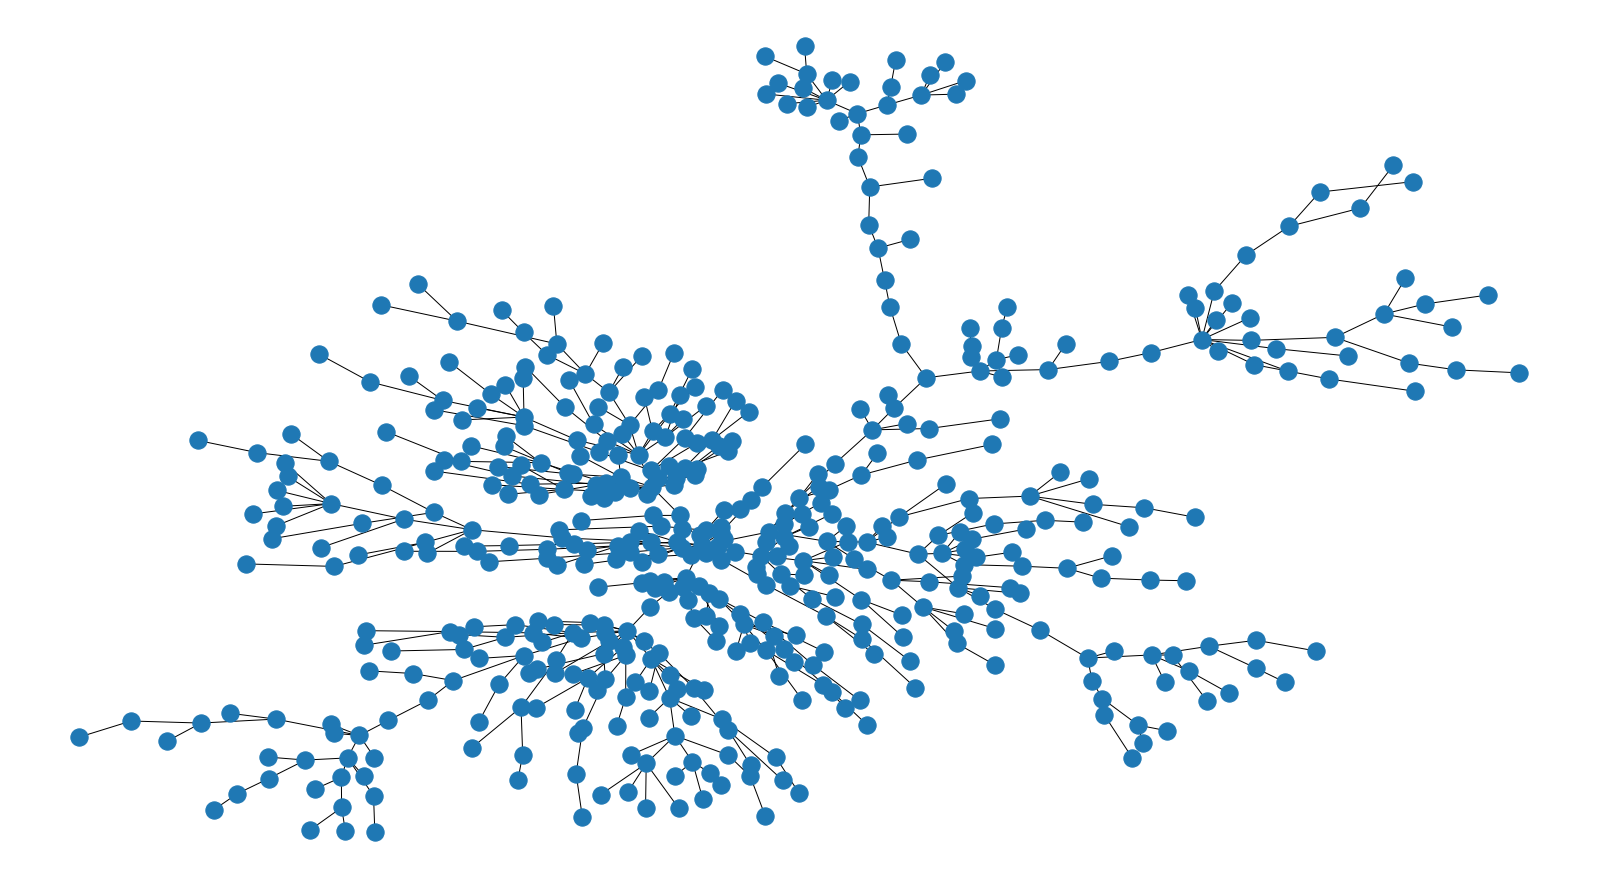

In [ ]:
fig = plt.figure(figsize=(22, 12))
nx.draw_kamada_kawai(distance_graph_filtered)

### Creating a dataframe of source and target nodes with correlation strength from above MST

In [ ]:
# extracting the edges of the above graph and storing them in a list.
edges = list(distance_graph_filtered.edges)

# creating an empty list to store correlation strength between two nodes
list_edges = []

# looping through each edge
for edge in edges:
    list_edges.append((edge[0], # storing first node of the edge
                       edge[1], # storing second node of the edge
                       log_return_correlation.loc[edge[0]][edge[1]])) # storing the correlation strength between those two nodes

# creating a dataframe using the above list of edges
edges = pd.DataFrame(list_edges)

# renamning the columns
edges.columns = ['source', 'target', 'weight']

### Creating sentence like structures using random walk algorithm

In [ ]:
# initializing a StellarGraph object with the specified edges to perform graph-based machine learning tasks
G = StellarGraph(edges=edges)

In [ ]:
# printing some basic information about the Graph
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 503, Edges: 502

 Node types:
  default: [503]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [502]
        Weights: range=[0.336561, 0.997779], mean=0.765147, std=0.105559
        Features: none


### Generating random walks

In [ ]:
# creating an object to generate random walks
rw = BiasedRandomWalk(G)

# generating random walks on the graph G
weighted_walks = rw.run(
    nodes = G.nodes(), # specifying the starting nodes for the walks
    length=100, # the number of steps in each walk
    n=50, # the number of walks to start from each node
    p=0.5, # the return parameter, which controls the likelihood of immediately revisiting a node in the walk.
    q=2.0, # the in-out parameter, which allows the search to differentiate between "inward" and "outward" nodes.
    weighted=True, # weights will be used when choosing the next step of the walk.
    seed=42 # setting a seed for the random number generator, ensuring that the walks are reproducible
)

### Training a Word2Vec model

In [ ]:
weighted_model = Word2Vec(
    weighted_walks, # training data for the model
    window=5, # model will learn to predict a node based on the 5 nodes to its left and right in the walk.
    min_count=0, # don't ignore any nodes
    sg=1, # defines the training algorithm, which is skip-gram in this case
    workers=8 # number of worker threads to train the model
)

### Results

In [ ]:
# finding out the nodes that are most similar to the node 'JPM'.
weighted_model.wv.most_similar('JPM')

[('BAC', 0.9446576237678528),
 ('GS', 0.9360323548316956),
 ('C', 0.9121179580688477),
 ('MS', 0.9060014486312866),
 ('WFC', 0.8757656216621399),
 ('CFG', 0.7548577189445496),
 ('FITB', 0.577122151851654),
 ('PNC', 0.5704739689826965),
 ('HBAN', 0.5478525757789612),
 ('RF', 0.5212191939353943)]

### Saving the embeddings

In [ ]:
# saving the trained Word2Vec model
weighted_model.save('weighted_model')

# loading a previously saved Word2Vec model from a file named 'weighted_model'
model = gensim.models.word2vec.Word2Vec.load('weighted_model')

# opening the file 'embeddings.tsv' in write mode
with open('embeddings.tsv', 'w+') as tensors:

    # opening the file 'metadata.tsv' in write mode
    with open('metadata.tsv', 'w+') as metadata:

        # iterating over each word in the vocabulary of the Word2Vec model.
        for word in model.wv.index_to_key:

            # encodes the word as bytes
            encoded = word.encode()

            # writing each word to the 'metadata.tsv' file, followed by a newline character
            metadata.write(word + '\n')

            # converting the word's embedding vector to a string representation separated by a tab character
            vector_raw = '\t'.join(map(str, model.wv[word]))

            # writing the string representation of the embedding vector to the 'embeddings.tsv' file
            tensors.write(vector_raw + '\n')